Install 

In [1]:
!pip3 install py_vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 3.9 MB/s 
  Created wheel for py-vncorenlp: filename=py_vncorenlp-0.1.3-py3-none-any.whl size=4307 sha256=754747889509893928cd9b15015e2d5a753cdf3bfc13e15475f1fa4e6265ebfc
  Stored in directory: /root/.cache/pip/wheels/d7/73/13/6b1f2c14831151fc1417f3dc1fa6b241e27ad13f8c83691753
Successfully built py-vncorenlp


**Import Library**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from string import punctuation
import py_vncorenlp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow import keras
from keras import layers
from keras.utils.vis_utils import plot_model
import re
from wordcloud import WordCloud

import pickle
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Download

In [3]:
path = '/content/Food-Comments-Sentiment-Analysis'
isExist = os.path.exists(path)
if not isExist:
  !git clone https://github.com/cuongprotector/Food-Comments-Sentiment-Analysis.git

Cloning into 'Food-Comments-Sentiment-Analysis'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 54 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [4]:
path = '/content/VnCoreNLP'
isExist = os.path.exists(path)
if not isExist:
  !git clone https://github.com/vncorenlp/VnCoreNLP.git

Cloning into 'VnCoreNLP'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 233 (delta 12), reused 1 (delta 0), pack-reused 212
Receiving objects: 100% (233/233), 214.22 MiB | 25.42 MiB/s, done.
Resolving deltas: 100% (88/88), done.


**Read .csv**

In [5]:
food_train_df = pd.read_csv('/content/Food-Comments-Sentiment-Analysis/food_train.csv',encoding='UTF8')
try:
  food_train_df.drop(columns=["Unnamed: 0"],axis=1,inplace=True)
except:
  pass

In [6]:
food_train_df.head()

,Comment,Rating
0,"Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trô...",1
1,Gọi ship 1 xuất cari gà bánh naan và 3 miếng g...,0
2,"Thời tiết lạnh như này, cả nhà rủ nhau đến leg...",1
3,Em có đọc review thấy mng bảo trà sữa nướng đề...,0
4,"Đồ ăn rất ngon, nhà hàng cũng rất đẹp, tất cả ...",1


**EDA**

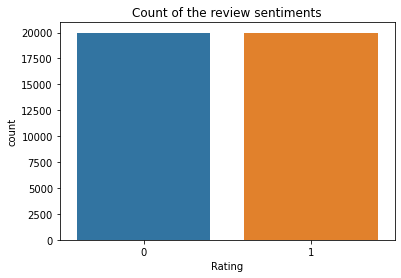

0    19988
1    19981
Name: Rating, dtype: int64


In [7]:
sns.countplot(food_train_df['Rating'])
plt.title('Count of the review sentiments')
plt.show()
print(food_train_df['Rating'].value_counts())

The distribution is unbiased.

In [8]:
# wordcloud of reviews with sentiment -> Positive (label 1)

def get_visuals(df,column_name,value):
    s=','
    for element in df[df[column_name]==value]['Comment']:
        s+=str(element)
    
    wordcloud=WordCloud(background_color='white',
                    random_state=101,
                   width=800,
                   height=800).generate(s)
    
    plt.figure(figsize=(12,8))
    plt.axis('off')
    plt.grid(False)
    plt.imshow(wordcloud)
    plt.show()

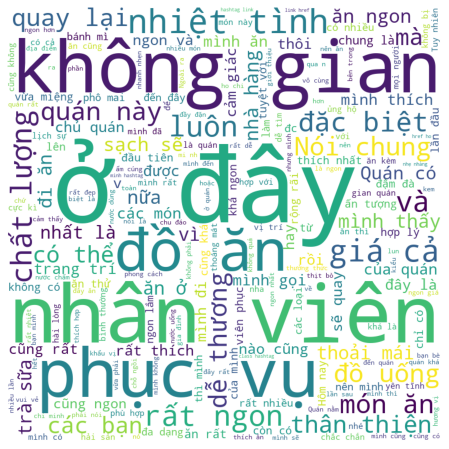

In [9]:
get_visuals(food_train_df,'Rating',1)

**Text processing**

In [7]:
try:
  model = py_vncorenlp.VnCoreNLP(save_dir='/content/VnCoreNLP')
except:
  pass

In [8]:
#get vocabrary 
def get_wordbag(paragraph,vocab):
  txt = paragraph.split(' ')
  for word in txt:
    if word not in vocab:
      vocab[word.lower()] = 1
    else:
      vocab[word.lower()] = vocab[word.lower()] + 1
#get process to training
def processing_paragraph(paragraph,posTag_useness = []):
  y = model.annotate_text(paragraph)
  bag = []
  for i in range(len(y)):
    H = pd.DataFrame(data=y[i])
    for j in range(len(H['wordForm'])):
      if H['posTag'][j] not in posTag_useness:
        bag.append(H['wordForm'][j].lower())
  return bag

In [ ]:
posTag_useness = ['Np','Nc','Nu','P','L','M','E','Cc','T']
processing_paragraph(food_train_df['Comment'][20],posTag_useness = posTag_useness)

In [13]:
All_comment = food_train_df['Comment'].values
Pos_Comment = [ food_train_df["Comment"][i] for i in range(len(food_train_df["Comment"])) if food_train_df["Rating"][i] ==1 ]
Neg_Comment = [ food_train_df["Comment"][i] for i in range(len(food_train_df["Comment"])) if food_train_df["Rating"][i] ==0 ]

In [14]:
pos_word_bag = {}
neg_word_bag = {}
for i in range(len(Pos_Comment)):
  get_wordbag(Pos_Comment[i],pos_word_bag)
for i in range(len(Neg_Comment)):
  get_wordbag(Neg_Comment[i],neg_word_bag)
pos_word_bag_df  = {
    'Word' : pos_word_bag.keys(),
    'Frequency' : pos_word_bag.values()
}
neg_word_bag_df  = {
    'Word' : neg_word_bag.keys(),
    'Frequency' : neg_word_bag.values()
}
neg_df = pd.DataFrame(data = neg_word_bag_df)
pos_df = pd.DataFrame(data = pos_word_bag_df)
neg_df = neg_df.sort_values(by=['Frequency'],ascending=False)
pos_df = pos_df.sort_values(by=['Frequency'],ascending=False)

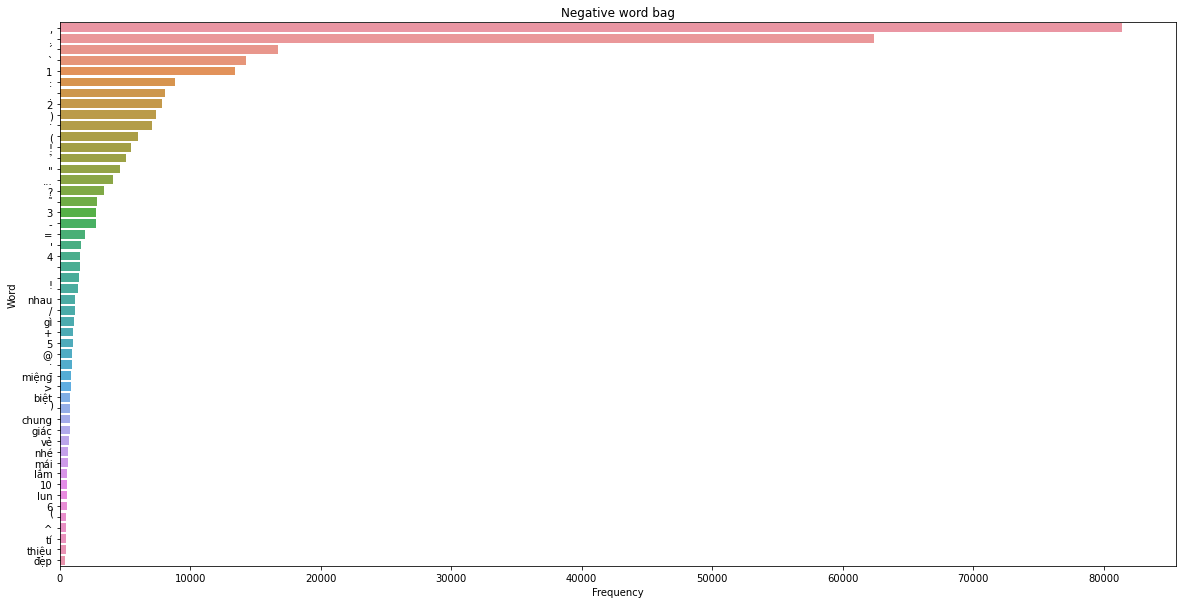

In [15]:
plt.figure(1,figsize=(20,10))
sns.barplot(data = neg_df[['Frequency','Word']][:50],x='Frequency',y='Word')
plt.title("Negative word bag")
plt.show()

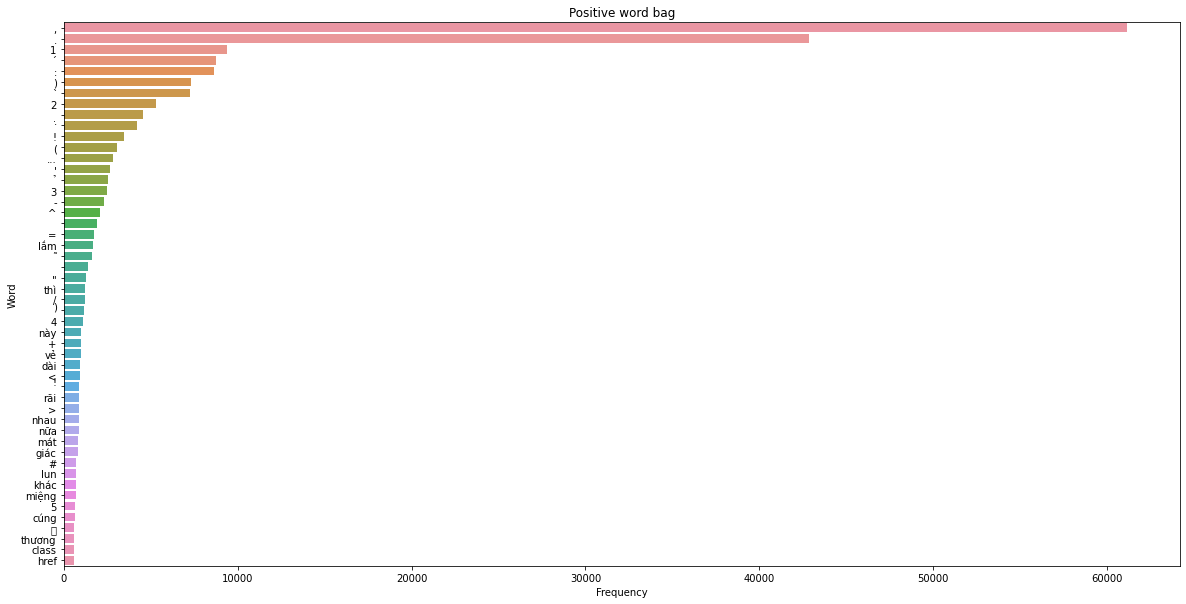

In [16]:
plt.figure(2,figsize=(20,10))
sns.barplot(data = pos_df[['Frequency','Word']][:50],x='Frequency',y='Word')
plt.title("Positive word bag")
plt.show()

In [17]:
posTag_useness = ['Np','Nc','Nu','P','L','M','E','Cc','T']
Pos_para =  []
Neg_para = []
for i in range(len(Pos_Comment)):
  bag = processing_paragraph(Pos_Comment[i],posTag_useness = posTag_useness)
  Pos_para.append(' '.join(bag))
for i in range(len(Neg_Comment)):
  bag = processing_paragraph(Neg_Comment[i],posTag_useness = posTag_useness)
  Neg_para.append(' '.join(bag))

In [18]:
processed = {
    'content' : Pos_para + Neg_para,
    'label' : [1 for i in range(len(Pos_para))] + [0 for i in range(len(Neg_para))]
}
train_df = pd.DataFrame(data = processed)
train_df = train_df.sample(frac = 1).reset_index(drop=True)
train_df.to_csv('/content/train_df.csv')

In [19]:
train_df.head()

,content,label
0,lần đầu ăn cj mà có_khi cũng là lần cuối . bán...,0
1,trưa nóng qua nhà nhỏ bạn làm thuyết_trình có ...,1
2,theo như thấy thì chỗ rất ấm_cúng đẹp . phục_v...,1
3,"rất thích ô cửa xanh , trường_kỷ gỗ kết_hợp nộ...",1
4,"quán ồn_ào , nước uống thì dở tệ , bỏ ly luôn ...",0


In [20]:
train_df['label'].value_counts()

0    19988
1    19981
Name: label, dtype: int64

In [9]:
sub_df = pd.read_csv("/content/Food-Comments-Sentiment-Analysis/test.csv",encoding='UTF8')
sub_df.head()

,Unnamed: 0,RevId,UserId,Comment,image_urls
0,0,781115,1326532,Trà táo 35k\r\nCookie socola 38k \r\nNước ở đâ...,['https://images.foody.vn/res/g8/73091/s800/fo...
1,1,1219481,422306,Hôm rồi trung tâm mình tổ chức noel party ở đâ...,['https://images.foody.vn/res/g1/33/s800/foody...
2,2,1703765,9779143,Thịt gà của quán là nhất đấy. Đi ăn gọi liền 4...,['https://images.foody.vn/res/g66/659655/s800/...
3,3,4870346,12924388,Hai đứa ăn xong đau bụng cả ngày\r\nChân gà ok...,['https://images.foody.vn/res/g78/772244/s800/...
4,4,2638711,1134279,Mình vừa thử trưa nay. Điểm cộng đầu tiên là b...,['https://images.foody.vn/res/g74/737874/s800/...


In [14]:
sub_df['Comment'] = sub_df['Comment'].astype(str)

In [15]:
posTag_useness = ['Np','Nc','Nu','P','L','M','E','Cc','T']
sub_para =  []
for i in range(len(sub_df['Comment'])):
  bag = processing_paragraph(sub_df['Comment'][i],posTag_useness = posTag_useness)
  sub_para.append(' '.join(bag))

In [ ]:
processed = {
    'content' : sub_para,
}
test_df = pd.DataFrame(data = processed)
test_df.to_csv('/content/subtest_df.csv')